# Experiment 2: What persists, exists

> Conducting the second experiment that is training the cellular automaton to maintain its form after it has reached the desired shape.

In [ ]:
#| default_exp what_persists_exists

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from NeuralCellularAutomata_PyTorch.core import *
from NeuralCellularAutomata_PyTorch.learning_to_grow import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [ ]:
batch_size = 8
n_epochs = 8000

In [ ]:
path = '../images/emoji_u1f98e.png'

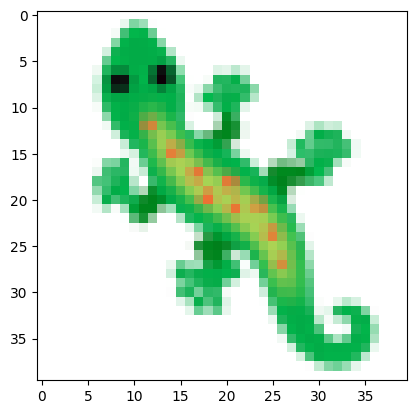

In [ ]:
img_tensor = load_image(path)

# Pool Training

We want to create a pool of samples, that will contain different stages of the generation process as initial states.

In [ ]:
#| export
class SamplePool:

    def __init__(self, pool_size=1024, loss_fn=None, device=def_device):
        assert loss_fn is not None, "You need to provide a loss function"
        self.pool_size = pool_size
        self.loss_fn = loss_fn
        self.reset()
    
    def make_seed(self, sz=[1, 16, TARGET_SIZE, TARGET_SIZE]):
        seed = torch.zeros(sz).to(def_device) 
        seed[:, 3:, TARGET_SIZE//2, TARGET_SIZE//2] = 1.0
        return seed

    def reset(self):
        self.seed = self.make_seed()
        self.pool = self.seed.repeat(self.pool_size, 1, 1, 1)

    def sample(self, num_samples=8):

        # selecting a random sample from the pool
        self.idxs = torch.randperm(self.pool_size)[:num_samples]
        batch = self.pool[self.idxs, ...]

        
        # find the sample in the batch with the highest loss
        losses = self.loss_fn(batch[:, :4, :, :])
        # and replace it with the seed
        # to avoid "catastrofic forgetting" 
        # (i.e. forgetting how to generate the target from the seed)
        replace_idx = torch.argmax(losses).item()
        batch[replace_idx] = self.seed[0]


        return batch
    
    def update(self, new_samples):
        new_samples = new_samples.detach()
        # replace the old samples with the newly generated ones
        self.pool[self.idxs] = new_samples

In the SamplePool, we use a loss function to select the sample inside the batch with the highest loss and replace it with the original seed. To do so, we will use the MSE loss. 

In [ ]:
#| export
def mse(pred, target, dim=1): 
    return ((pred - target) * (pred - target)).sum(dim).sum(dim=(1, 2))

In [ ]:
loss_fn = partial(mse, target=img_tensor.repeat(batch_size, 1, 1, 1).to(def_device))

In [ ]:
pool = SamplePool(1024, loss_fn=loss_fn)
batch = pool.sample()
batch.shape

torch.Size([8, 16, 40, 40])

We also need a function that will visualize a batch of inputs to validate that the sampling of the pool works as expected.

In [ ]:
#| export 
def vis_batch(batch):
    B, C, H, W = batch.shape
    if C > 4:
        batch = batch[:, :4, :, :]

    plt.figure(figsize=(16, 16))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        plt.imshow(batch[i].detach().cpu().permute(1, 2, 0))
        plt.axis('off')    

    plt.show()

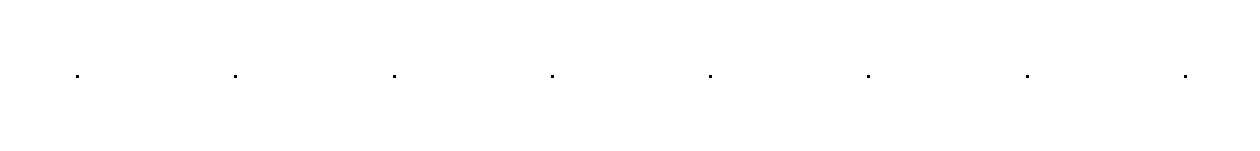

In [ ]:
vis_batch(batch)

# Training Loop

In [ ]:
#|eval: false


# Instantiate the model
ca = CAModel(CHANNEL_N).to(def_device)

# Optimization
lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
optimizer = torch.optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

target = img_tensor.repeat(batch_size, 1, 1, 1)

In [ ]:
#|eval: false

for i in tqdm(range(n_epochs)):
    # zero the optimizer
    optimizer.zero_grad()

    # set the number of steps to take
    steps = torch.randint(64, 96, (1,)).item()

    # sample the pool to get the input
    model_in = pool.sample()

    # activate the model
    res = ca(model_in, steps=steps)

    # calculate the loss
    loss = F.mse_loss(res[:, :4], target) # we only care about the RGBA channels

    # update the pool
    pool.update(res)

    # log the loss
    if i%500 == 0:
        print(f"Epoch: {i} Loss: {loss.item()}")

    # backpropagate the loss and update the weights
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|                                        | 1/8000 [00:00<1:26:39,  1.54it/s]

Epoch: 0 Loss: 0.11318174749612808


  6%|██▌                                     | 503/8000 [00:35<09:04, 13.77it/s]

Epoch: 500 Loss: 0.025092191994190216


 13%|████▉                                  | 1003/8000 [01:09<07:48, 14.92it/s]

Epoch: 1000 Loss: 0.015459218993782997


 19%|███████▎                               | 1503/8000 [01:43<07:31, 14.38it/s]

Epoch: 1500 Loss: 0.008353400975465775


 25%|█████████▊                             | 2003/8000 [02:17<06:55, 14.43it/s]

Epoch: 2000 Loss: 0.0046185762621462345


 31%|████████████▏                          | 2503/8000 [02:51<06:19, 14.48it/s]

Epoch: 2500 Loss: 0.0031142488587647676


 38%|██████████████▋                        | 3003/8000 [03:26<05:46, 14.40it/s]

Epoch: 3000 Loss: 0.0015645724488422275


 44%|█████████████████                      | 3503/8000 [04:00<05:28, 13.70it/s]

Epoch: 3500 Loss: 0.0010012438287958503


 50%|███████████████████▌                   | 4003/8000 [04:35<04:51, 13.71it/s]

Epoch: 4000 Loss: 0.0005030333995819092


 56%|█████████████████████▉                 | 4503/8000 [05:10<04:02, 14.45it/s]

Epoch: 4500 Loss: 0.0005954373045824468


 63%|████████████████████████▍              | 5001/8000 [05:44<03:34, 14.00it/s]

Epoch: 5000 Loss: 0.0009438891429454088


 69%|██████████████████████████▊            | 5503/8000 [06:23<03:19, 12.54it/s]

Epoch: 5500 Loss: 0.000864389818161726


 75%|█████████████████████████████▎         | 6001/8000 [07:03<02:30, 13.32it/s]

Epoch: 6000 Loss: 0.00047235662350431085


 81%|███████████████████████████████▋       | 6503/8000 [07:44<02:02, 12.19it/s]

Epoch: 6500 Loss: 0.00031021377071738243


 88%|██████████████████████████████████▏    | 7001/8000 [08:24<01:20, 12.39it/s]

Epoch: 7000 Loss: 0.00025668973103165627


 94%|████████████████████████████████████▌  | 7503/8000 [09:04<00:35, 13.94it/s]

Epoch: 7500 Loss: 0.00032552078482694924


100%|███████████████████████████████████████| 8000/8000 [09:43<00:00, 13.70it/s]


In [ ]:
#|eval: false

images = ca.grow_animation(seed, 200)
display_animation(images)

The automato manages to maintain it's shape as time passes. 

### Visualize a batch from the updated pool. 

During the training process we update the samples inside the pool. 
Let's visualize how a sample would look like after the training process is completed. 

In [ ]:
#| eval: false
batch = pool.sample()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


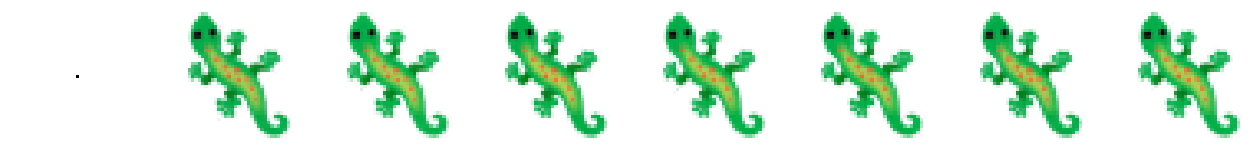

In [ ]:
#| eval: false
vis_batch(batch)